In [20]:
from datetime import datetime, timedelta,timezone
import requests
import pandas as pd
import matplotlib.pyplot as plt

def backtest_ilp(start_date, end_date, X_reserve, Y_reserve, pool_id, ddpg_agent_path, ppo_agent_path, rebalancing_frequency,agent):
  
    current_date = datetime.strptime(start_date, '%d-%m-%y')
    end_date = datetime.strptime(end_date, '%d-%m-%y')
    
    while current_date <= end_date:
        curr_date_str = current_date.strftime('%Y-%m-%d')
        # Step 3: Predict new positions
        ddpg_action, ppo_action = get_inference(ddpg_agent_path, ppo_agent_path, pool_id, curr_date_str)
        
        # Step 4: Rebalance portfolio
        start_interval = current_date
        end_interval = current_date + timedelta(days=rebalancing_frequency)
        start_date_str = start_interval.strftime('%Y-%m-%d %H:%M:%S')
        end_date_str = end_interval.strftime('%Y-%m-%d %H:%M:%S')

        if agent=="ddpg":
            price_lower=ddpg_action['price_lower']
            price_upper=ddpg_action['price_upper']
        else:
            price_lower=ppo_action['price_lower']
            price_upper=ppo_action['price_upper']
            

        response = simulate_position(X_reserve, Y_reserve, start_date_str, end_date_str, price_lower, price_upper)
        response_json = response.json()
        data_df,results_df=save_data_to_df(response_json)

        if 'LP_positions' not in response_json:
            print(f"Error: 'LP_positions' not found in response or response is None: {response_json}")
            break

        # Extract values from the first position
        
        # Move to the next rebalancing date
        current_date += timedelta(days=rebalancing_frequency)
    return data_df,results_df
    # Create DataFrame and plot results

def get_inference(ddpg_agent_path='model_storage/ddpg/ddpg_1', ppo_agent_path='model_storage/ppo/lstm_actor_critic_batch_norm', pool_id="0xcbcdf9626bc03e24f779434178a73a0b4bad62ed",date_str='2024-05-05'):
    url = "http://127.0.0.1:8000/predict_action/"
    data = {
        "pool_id": pool_id,
        "ddpg_agent_path": ddpg_agent_path,
        "ppo_agent_path": ppo_agent_path,
        "date_str":date_str
    }
    response = requests.post(url, json=data)
    response_json = response.json()
    ddpg_action = response_json['ddpg_action']
    ppo_action = response_json['ppo_action']
    
    return ddpg_action, ppo_action

def simulate_position(X_reserve=0.01, Y_reserve=0.18, start_date="2024-03-01 00:00:00", end_date="2024-03-29 00:00:00", lower_price=16.0, upper_price=20.0):
    vector = {
        "X": X_reserve,
        "Y": Y_reserve,
        "positions": [
            {
                "start": start_date,
                "end": end_date,
                "lower_price": lower_price,
                "upper_price": upper_price,
            },
        ]
    }
    url = "http://localhost:5050/MVP"
    response = requests.post(url, json=vector)
    print(response.text)

    return response


def save_data_to_df(response_json):
    data = []
    for position in response_json.get('LP_positions', []):
        burn_data = position.get('burn', {})
        info_data = position.get('info', {})
        mint_data = position.get('mint', {})
        swap_data = position.get('swap', {})

        data.append({
            
            'start': info_data.get('start'),
            'end': info_data.get('end'),
            'lower_price': info_data.get('lower_price'),
            'upper_price': info_data.get('upper_price'),
            'X_start': info_data.get('X_start'),
            'Y_start': info_data.get('Y_start'),
            'liquidity': mint_data.get('liquidity'),
            'X_left': mint_data.get('X_left'),
            'X_mint': mint_data.get('X_mint'),
            'Y_left': mint_data.get('Y_left'),
            'Y_mint': mint_data.get('Y_mint'),

            'X_fee': burn_data.get('X_fee'),
            'X_reserve': burn_data.get('X_reserve'),
            'Y_fee': burn_data.get('Y_fee'),
            'Y_reserve': burn_data.get('Y_reserve'),
            'APR': info_data.get('APR'),
            'Impermanent_loss': info_data.get('Impermanent_loss'),
            'PnL': info_data.get('PnL'),  
            'Yield': info_data.get('Yield'),

            #'lower_nearest_tick': mint_data.get('lower_nearest_tick'),
            #'pool_price': mint_data.get('pool_price'),
            #'pool_tick': mint_data.get('pool_tick'),
            #'upper_nearest_tick': mint_data.get('upper_nearest_tick'),
            #'X_after_swap': swap_data.get('X_after_swap'),
            #'X_swap': swap_data.get('X_swap'),
            #'Y_after_swap': swap_data.get('Y_after_swap'),
            #'Y_swap': swap_data.get('Y_swap'),
            #'fee_paid': swap_data.get('fee_paid'),
            #'swap_sqrtPriceX96': swap_data.get('sqrtPriceX96'),
            #'swap_price': swap_data.get('swap_price'),
            #'swap_token': swap_data.get('swap_token')
        })

    final_result = response_json.get('final_result', {})
    final_result_data = {
        'final_PnL': final_result.get('PnL'),
        'final_fee_value': final_result.get('fee_value'),
        'final_fee_yield': final_result.get('fee_yield'),
        'final_impermanent_loss': final_result.get('impermanent_loss'),
        'final_portfolio_value_end': final_result.get('portfolio_value_end'),
        'final_portfolio_value_start': final_result.get('portfolio_value_start')
    }

    data_df = pd.DataFrame(data)
    final_result_df = pd.DataFrame([final_result_data])

    return data_df, final_result_df
# Example usage
start_date = '01-01-24'
end_date = '29-03-24'
ddpg_agent_path='model_storage/ddpg/ddpg_1'
ppo_agent_path='model_storage/ppo/lstm_actor_critic_batch_norm'
pool_id="0xcbcdf9626bc03e24f779434178a73a0b4bad62ed"
agent="ppo"
X_reserve = 2
Y_reserve = 10
rebalancing_frequency = 7  
data_df,results_df=backtest_ilp(start_date, end_date, X_reserve,Y_reserve,pool_id, ddpg_agent_path, ppo_agent_path, rebalancing_frequency,agent)


{"LP_positions":[{"burn":{"X_collect":113728344,"X_fee":512399,"X_reserve":113215945,"Y_collect":26768634743963882788,"Y_fee":164790941744684878,"Y_reserve":26603843802219197910,"burn_price":197509177937.5386,"sqrtPriceX96":35210583687103516838365045957836641},"info":{"APR":-28.5257317582674,"Impermanent_loss":1.08441142140678,"PnL":-0.5470688282407447,"X_start":2,"X_start_wei":200000000,"Y_start":10,"Y_start_wei":10000000000000000000,"Yield":0.537342593166036,"duration":604800.0,"end":"2024-01-08 00:00:00","lower_price":18.28247528448738,"start":"2024-01-01 00:00:00","upper_price":21.091693836492663},"mint":{"X_left":797756,"X_mint":228218917,"Y_left":950785949,"Y_mint":4611055009709031335,"liquidity":1558241706180069,"lower_nearest_tick":259320,"pool_price":185163423450.05405,"pool_tick":260103,"upper_nearest_tick":260760},"swap":{"X_after_swap":229016673,"X_swap":-29016673,"Y_after_swap":4611055010659817284,"Y_swap":5372826509810750464,"fee_paid":16118479529432252,"sqrtPriceX96":340

In [25]:
from datetime import datetime, timedelta, timezone
import requests
import pandas as pd
import matplotlib.pyplot as plt

def backtest_ilp(start_date, end_date, X_reserve, Y_reserve, pool_id, ddpg_agent_path, ppo_agent_path, rebalancing_frequency, agent):
    current_date = datetime.strptime(start_date, '%d-%m-%y')
    end_date = datetime.strptime(end_date, '%d-%m-%y')

    all_data = []
    final_results = None

    while current_date <= end_date:
        curr_date_str = current_date.strftime('%Y-%m-%d')
        # Step 3: Predict new positions
        ddpg_action, ppo_action = get_inference(ddpg_agent_path, ppo_agent_path, pool_id, curr_date_str)
        
        # Step 4: Rebalance portfolio
        start_interval = current_date
        end_interval = current_date + timedelta(days=rebalancing_frequency)
        start_date_str = start_interval.strftime('%Y-%m-%d %H:%M:%S')
        end_date_str = end_interval.strftime('%Y-%m-%d %H:%M:%S')

        if agent == "ddpg":
            price_lower = ddpg_action['price_lower']
            price_upper = ddpg_action['price_upper']
        else:
            price_lower = ppo_action['price_lower']
            price_upper = ppo_action['price_upper']

        response = simulate_position(X_reserve, Y_reserve, start_date_str, end_date_str, price_lower, price_upper)
        response_json = response.json()
        data_df, results_df = save_data_to_df(response_json)

        if 'LP_positions' not in response_json:
            print(f"Error: 'LP_positions' not found in response or response is None: {response_json}")
            break

        # Append the data to the all_data list
        all_data.extend(data_df.to_dict('records'))
        final_results = results_df.to_dict('records')[0]

        # Move to the next rebalancing date
        current_date += timedelta(days=rebalancing_frequency)

    # Create DataFrame from all_data
    final_data_df = pd.DataFrame(all_data)
    final_results_df = pd.DataFrame([final_results])

    return final_data_df, final_results_df

def get_inference(ddpg_agent_path='model_storage/ddpg/ddpg_1', ppo_agent_path='model_storage/ppo/lstm_actor_critic_batch_norm', pool_id="0xcbcdf9626bc03e24f779434178a73a0b4bad62ed", date_str='2024-05-05'):
    url = "http://127.0.0.1:8000/predict_action/"
    data = {
        "pool_id": pool_id,
        "ddpg_agent_path": ddpg_agent_path,
        "ppo_agent_path": ppo_agent_path,
        "date_str": date_str
    }
    response = requests.post(url, json=data)
    response_json = response.json()
    ddpg_action = response_json['ddpg_action']
    ppo_action = response_json['ppo_action']
    
    return ddpg_action, ppo_action

def simulate_position(X_reserve=0.01, Y_reserve=0.18, start_date="2024-03-01 00:00:00", end_date="2024-03-29 00:00:00", lower_price=16.0, upper_price=20.0):
    vector = {
        "X": X_reserve,
        "Y": Y_reserve,
        "positions": [
            {
                "start": start_date,
                "end": end_date,
                "lower_price": lower_price,
                "upper_price": upper_price,
            },
        ]
    }
    url = "http://localhost:5050/MVP"
    response = requests.post(url, json=vector)
    print(response.text)

    return response

def save_data_to_df(response_json):
    data = []
    for position in response_json.get('LP_positions', []):
        burn_data = position.get('burn', {})
        info_data = position.get('info', {})
        mint_data = position.get('mint', {})
        swap_data = position.get('swap', {})

        data.append({
            'start': info_data.get('start'),
            'end': info_data.get('end'),
            'curr_price':burn_data.get('burn_price')/1e10,
            'lower_price': info_data.get('lower_price'),
            'upper_price': info_data.get('upper_price'),
            'X_start': info_data.get('X_start'),
            'Y_start': info_data.get('Y_start'),
            'liquidity': mint_data.get('liquidity'),
            'X_left': mint_data.get('X_left'),
            'X_mint': mint_data.get('X_mint'),
            'Y_left': mint_data.get('Y_left'),
            'Y_mint': mint_data.get('Y_mint'),
            'X_fee': burn_data.get('X_fee'),
            'X_reserve': burn_data.get('X_reserve'),
            'Y_fee': burn_data.get('Y_fee'),
            'Y_reserve': burn_data.get('Y_reserve'),
            'APR': info_data.get('APR'),
            'Impermanent_loss': info_data.get('Impermanent_loss'),
            'PnL': info_data.get('PnL'),
            'Yield': info_data.get('Yield')
        })

    final_result = response_json.get('final_result', {})
    final_result_data = {
        'final_PnL': final_result.get('PnL'),
        'final_fee_value': final_result.get('fee_value'),
        'final_fee_yield': final_result.get('fee_yield'),
        'final_impermanent_loss': final_result.get('impermanent_loss'),
        'final_portfolio_value_end': final_result.get('portfolio_value_end'),
        'final_portfolio_value_start': final_result.get('portfolio_value_start')
    }

    data_df = pd.DataFrame(data)
    final_result_df = pd.DataFrame([final_result_data])

    return data_df, final_result_df

# Example usage
start_date = '01-01-24'
end_date = '29-03-24'
ddpg_agent_path = 'model_storage/ddpg/ddpg_1'
ppo_agent_path = 'model_storage/ppo/lstm_actor_critic_batch_norm'
pool_id = "0xcbcdf9626bc03e24f779434178a73a0b4bad62ed"
agent = "ddpg"
X_reserve = 2
Y_reserve = 10
rebalancing_frequency = 7

data_df, results_df = backtest_ilp(start_date, end_date, X_reserve, Y_reserve, pool_id, ddpg_agent_path, ppo_agent_path, rebalancing_frequency, agent)

{"LP_positions":[{"burn":{"X_collect":178727316,"X_fee":104677,"X_reserve":178622639,"Y_collect":14129076470437220735,"Y_fee":33659229967493371,"Y_reserve":14095417240469727364,"burn_price":197535436473.07245,"sqrtPriceX96":35212924205261462429068416241584052},"info":{"APR":-7.692071448274949,"Impermanent_loss":0.25727446769335977,"PnL":-0.14751917846006754,"X_start":2,"X_start_wei":200000000,"Y_start":10,"Y_start_wei":10000000000000000000,"Yield":0.10975528923329743,"duration":604800.0,"end":"2024-01-08 00:00:00","lower_price":16.011589631658186,"start":"2024-01-01 00:00:00","upper_price":35.21672000161635},"mint":{"X_left":24862,"X_mint":202102334,"Y_left":180435704,"Y_mint":9604939469429175329,"liquidity":317496546662132,"lower_nearest_tick":258000,"pool_price":185163423450.05405,"pool_tick":260104,"upper_nearest_tick":265860},"swap":{"X_after_swap":202127196,"X_swap":-2127196,"Y_after_swap":9604939469609611033,"Y_swap":393878893709261184,"fee_paid":1181636681127783,"sqrtPriceX96":3

In [26]:
data_df

,start,end,curr_price,lower_price,upper_price,X_start,Y_start,liquidity,X_left,X_mint,Y_left,Y_mint,X_fee,X_reserve,Y_fee,Y_reserve,APR,Impermanent_loss,PnL,Yield
0,2024-01-01 00:00:00,2024-01-08 00:00:00,19.753544,16.011590,35.216720,2,10,317496546662132,24862,202102334,180435704,9604939469429175329,104677,178622639,33659229967493371,14095417240469727364,-7.692071,0.257274,-0.147519,0.109755
1,2024-01-08 00:00:00,2024-01-15 00:00:00,16.912155,17.141530,37.684107,2,10,321696110791910,1995,200166064,189463218,9966701663413363621,599344,254400087,84971739452076284,0,-72.987983,1.824953,-1.399770,0.425183
2,2024-01-15 00:00:00,2024-01-22 00:00:00,16.872375,14.491247,31.835534,2,10,306587673198862,30148,202761944,164916819,9526398248814397763,73127,203626272,11851127598497047,9380396355827068498,1.957703,0.017752,0.037545,0.055297
3,2024-01-22 00:00:00,2024-01-29 00:00:00,18.523486,14.653181,32.187253,2,10,309535170721922,87540,207225643,167592189,8762391680498516194,73815,172856574,31345997984246632,14838381487066385335,-16.016035,0.402847,-0.307157,0.095690
4,2024-01-29 00:00:00,2024-02-05 00:00:00,18.592213,15.934448,34.992654,2,10,316979641717941,195,200017740,179567766,9996667786500144143,69407,198661823,13657088884613963,10248298341602686608,2.880188,0.001056,0.055236,0.056293
5,2024-02-05 00:00:00,2024-02-12 00:00:00,19.168052,15.833501,34.768331,2,10,316437059468931,-1,196713749,529955032631773,10608627963984407203,76328,185605337,20482358098662823,12705663958048493665,-1.984859,0.110709,-0.038066,0.072643
6,2024-02-12 00:00:00,2024-02-19 00:00:00,18.139469,16.093313,35.333537,2,10,318163032192767,-1,191451694,1553296681223172,11632111222624808188,158197,211776096,18135987097568289,7842261879894878973,2.841026,0.046710,0.054485,0.101195
7,2024-02-19 00:00:00,2024-02-26 00:00:00,16.691785,15.058483,33.058154,2,10,312277014425993,-1,190238065,1805345191405834,11763638906119676918,183150,221368029,15652318294691752,6346879889291979753,-4.830618,0.199188,-0.092642,0.106546
8,2024-02-26 00:00:00,2024-03-04 00:00:00,18.075700,14.657154,32.172014,2,10,309566603675510,150224,211320355,167599929,8079652686840105872,189433,181728806,49503292533358330,13219639426885926533,0.083367,0.179858,0.001599,0.181456
9,2024-03-04 00:00:00,2024-03-11 00:00:00,17.816315,16.028059,35.166859,2,10,317492908030017,160705,211032601,180441691,7970626268139069060,280198,216455546,47254223459486028,6997440928110072607,3.015266,0.155124,0.057827,0.212951


In [27]:
results_df

,final_PnL,final_fee_value,final_fee_yield,final_impermanent_loss,final_portfolio_value_end,final_portfolio_value_start
0,0.049794,2.831569e+16,0.057736,0.007942,4.903963e+19,4.904353e+19


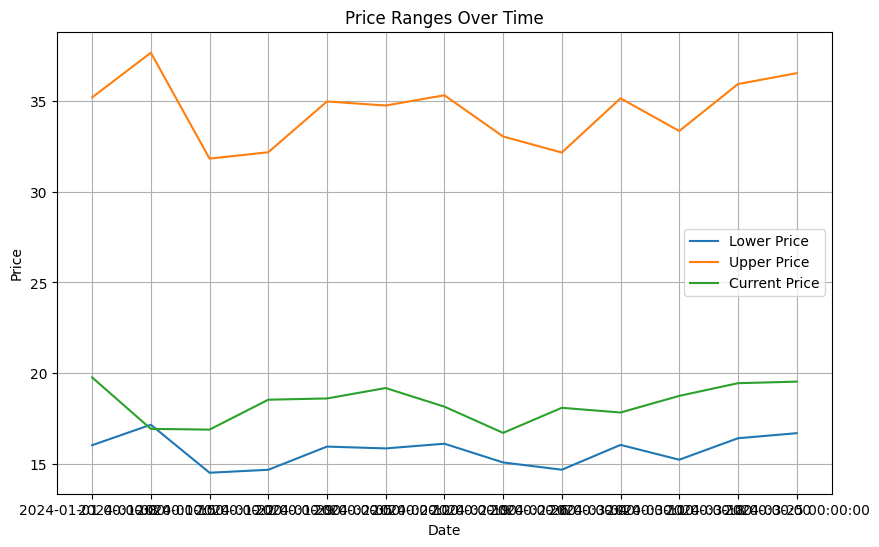

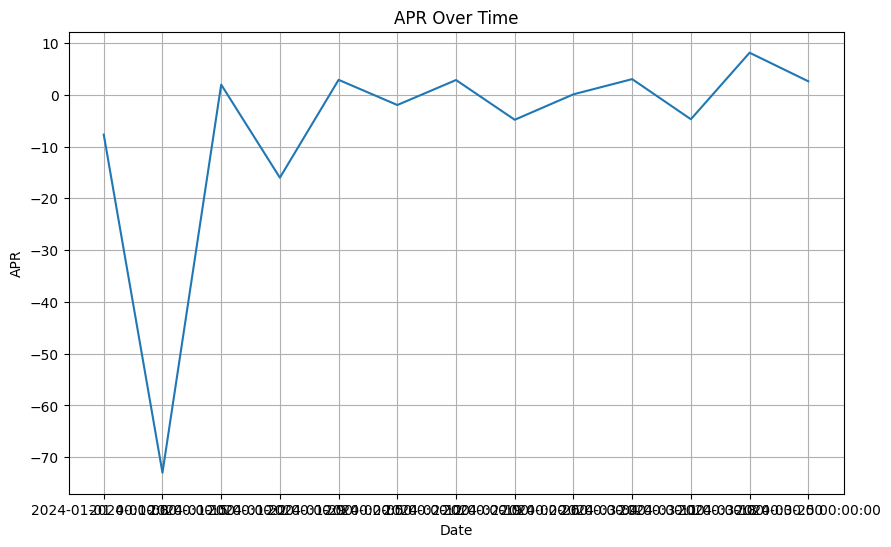

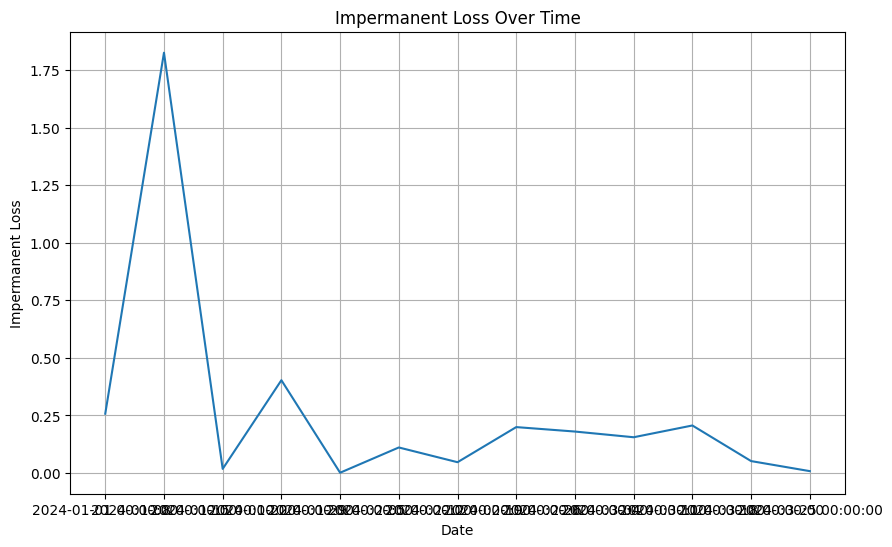

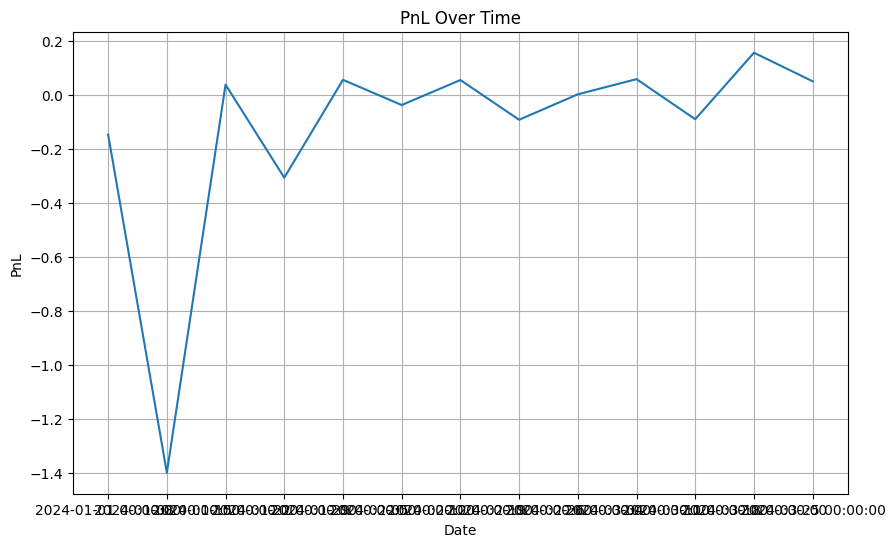

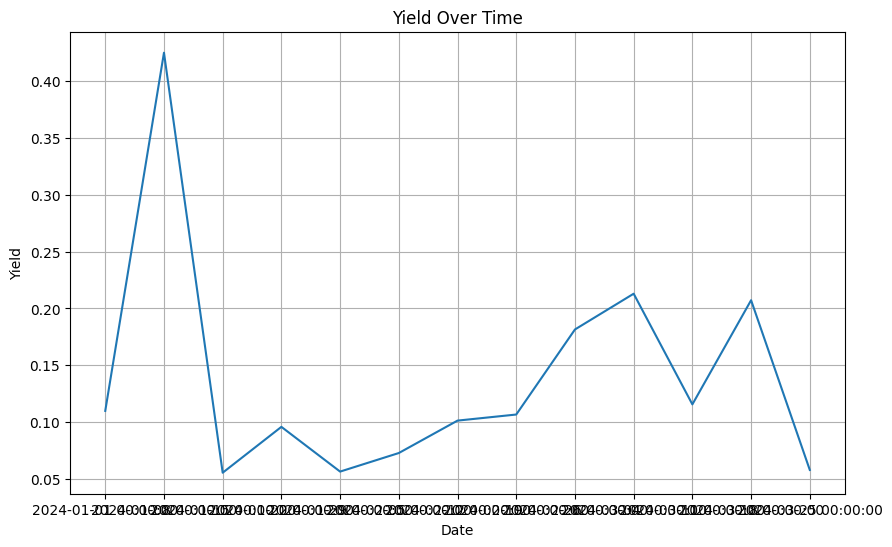

In [29]:
def plot_prices_over_time(data_df):
    plt.figure(figsize=(10, 6))
    plt.plot(data_df['start'], data_df['lower_price'], label='Lower Price')
    plt.plot(data_df['start'], data_df['upper_price'], label='Upper Price')
    plt.plot(data_df['start'], data_df['curr_price'], label='Current Price')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.title('Price Ranges Over Time')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_apr_over_time(data_df):
    plt.figure(figsize=(10, 6))
    plt.plot(data_df['start'], data_df['APR'])
    plt.xlabel('Date')
    plt.ylabel('APR')
    plt.title('APR Over Time')
    plt.grid(True)
    plt.show()

def plot_il_over_time(data_df):
    plt.figure(figsize=(10, 6))
    plt.plot(data_df['start'], data_df['Impermanent_loss'])
    plt.xlabel('Date')
    plt.ylabel('Impermanent Loss')
    plt.title('Impermanent Loss Over Time')
    plt.grid(True)
    plt.show()

def plot_pnl_over_time(data_df):
    plt.figure(figsize=(10, 6))
    plt.plot(data_df['start'], data_df['PnL'])
    plt.xlabel('Date')
    plt.ylabel('PnL')
    plt.title('PnL Over Time')
    plt.grid(True)
    plt.show()

def plot_yield_over_time(data_df):
    plt.figure(figsize=(10, 6))
    plt.plot(data_df['start'], data_df['Yield'])
    plt.xlabel('Date')
    plt.ylabel('Yield')
    plt.title('Yield Over Time')
    plt.grid(True)
    plt.show()

# Plotting the results
plot_prices_over_time(data_df)
plot_apr_over_time(data_df)
plot_il_over_time(data_df)
plot_pnl_over_time(data_df)
plot_yield_over_time(data_df)

In [ ]:
def plot_prices_over_time(data_df):
    plt.figure(figsize=(10, 6))
    plt.plot(data_df['start'], data_df['lower_price'], label='Lower Price')
    plt.plot(data_df['start'], data_df['upper_price'], label='Upper Price')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.title('Price Ranges Over Time')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def plot_apr_over_time(data_df):
    plt.figure(figsize=(10, 6))
    plt.plot(data_df['start'], data_df['APR'])
    plt.xlabel('Date')
    plt.ylabel('APR')
    plt.title('APR Over Time')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def plot_il_over_time(data_df):
    plt.figure(figsize=(10, 6))
    plt.plot(data_df['start'], data_df['Impermanent_loss'])
    plt.xlabel('Date')
    plt.ylabel('Impermanent Loss')
    plt.title('Impermanent Loss Over Time')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def plot_pnl_over_time(data_df):
    plt.figure(figsize=(10, 6))
    plt.plot(data_df['start'], data_df['PnL'])
    plt.xlabel('Date')
    plt.ylabel('PnL')
    plt.title('PnL Over Time')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def plot_yield_over_time(data_df):
    plt.figure(figsize=(10, 6))
    plt.plot(data_df['start'], data_df['Yield'])
    plt.xlabel('Date')
    plt.ylabel('Yield')
    plt.title('Yield Over Time')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


# Plotting the results
plot_prices_over_time(data_df)
plot_apr_over_time(data_df)
plot_il_over_time(data_df)
plot_pnl_over_time(data_df)
plot_yield_over_time(data_df)